# Algotytm przecinania się odcinków na płaszczyźnie

In [1]:
import numpy as np
import pandas as pd
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Przydatne funkcje 

In [2]:
def draw_example_1():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

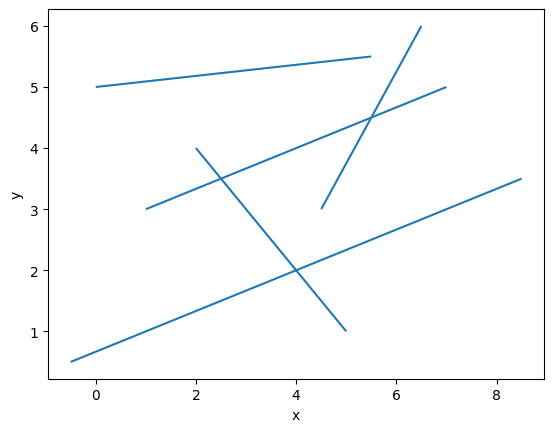

In [3]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

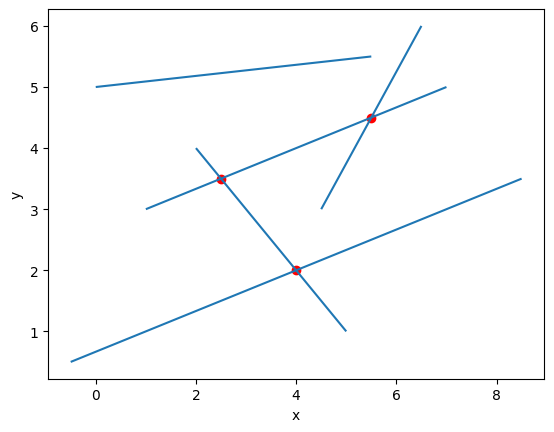

In [4]:
draw_example_2()

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [5]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    unique_x = np.random.uniform(0, max_x, size=(n,2))
    result = []
    for x1, x2 in unique_x:
        result.append( ((min(x1, x2),np.random.uniform(0, max_y)), (max(x1,x2),np.random.uniform(0, max_y))) )
    return result


In [6]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.094s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [7]:
random20segments = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

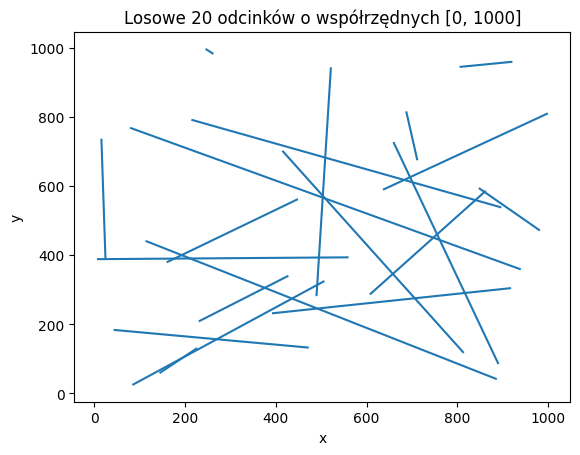

In [8]:
def show_segments(segments, title="None"):
    vis = Visualizer()
    vis.add_title(title)
    vis.add_line_segment(segments)
    return vis
show_segments(random20segments, "Losowe 20 odcinków o współrzędnych [0, 1000]").show()

Uzupełnij funkcję ```is_intersection```

In [9]:
def is_intersection(sections, eps=10 ** (-10)):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina
    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps: epsilon będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """
    from sortedcontainers import SortedSet
    from queue import PriorityQueue

    class Line:
        def __init__(self, p1, p2, idx):
            self.p1 = min(p1, p2)
            self.p2 = max(p1, p2)
            self.idx = idx
            self.a = (p2[1] - p1[1]) / (p2[0] - p1[0])
            self.b = p2[1] - self.a * p2[0]

    def get_y(x, line):
        return line.a * x + line.b

    class Broom:
        def __init__(self, segments):
            self.segments = segments
            self.Q = PriorityQueue()
            self.T = SortedSet(key=lambda line: get_y(line.p1[0], line))
            for i, segment in enumerate(self.segments):
                line = Line(segment[0], segment[1], i)
                self.Q.put((line.p1[0], 1, line))
                self.Q.put((line.p2[0], 0, line))

        def sweep(self):
            while not self.Q.empty():
                x, event, segment = self.Q.get()
                if event and self.insert(segment):
                    return True
                elif not event and self.delete(segment):
                    return True
            return False

        def insert(self, segment):
            self.T = SortedSet(self.T, key=lambda line: get_y(segment.p1[0], line))
            self.T.add(segment)
            index = self.T.index(segment)
            a = b = False
            if index > 0:
                a = self.check(segment, self.T[index-1])
            if index+1 < len(self.T):
                b = self.check(segment, self.T[index+1])
            return a or b

        def delete(self, segment):
            index = self.T.index(segment)
            self.T.pop(index)
            return self.check(self.T[index], self.T[index-1]) if 0 < index < len(self.T)-1 else False

        def check(self, segment1, segment2):
            a, b = segment1.p1, segment1.p2
            c, d = segment2.p1, segment2.p2
            t1 = ((c[0]-a[0])*(d[1]-c[1])-(c[1]-a[1])*(d[0]-c[0])) / ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0]))
            t2 = ((c[0]-a[0])*(b[1]-a[1])-(c[1]-a[1])*(b[0]-a[0])) / ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0]))
            if 0 <= t1 <= 1 and 0 <= t2 <= 1:
                return True
            return False
    
    return Broom(sections).sweep()

In [10]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.000s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Odpowiedź here

Uzupełnij funkcję ```is_intersection_with_visualization```

In [11]:
def is_intersection_with_visualization(sections, eps=10**(-12), title="None"):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    global glob, name
    from queue import PriorityQueue
    from sortedcontainers import SortedSet

    class Line:
        def __init__(self, p1, p2, idx):
            self.p1 = min(p1, p2)
            self.p2 = max(p1, p2)
            self.idx = idx
            self.a = (p2[1] - p1[1]) / (p2[0] - p1[0])
            self.b = p2[1] - self.a * p2[0]

    def get_y(x, line):
        return line.a * x + line.b

    class Broom:
        def __init__(self, segments):
            self.segments = segments
            self.Q = PriorityQueue()
            self.T = SortedSet(key=lambda line: get_y(line.p1[0], line))
            for i, segment in enumerate(self.segments):
                line = Line(segment[0], segment[1], i)
                self.Q.put((line.p1[0], 1, line))
                self.Q.put((line.p2[0], 0, line))
            self.stage = {}
            self.broom = None
            self.point = None
            self.low = min(min(b,d) for (_,b), (_,d)  in  self.segments)
            self.top = max(max(b,d) for (_,b), (_,d)  in  self.segments)

        def sweep(self):
            while not self.Q.empty():
                x, event, segment = self.Q.get()
                self.broom = vis.add_line(((x,self.low),(x,self.top)), color='purple')
                if event:
                    self.point = vis.add_point(segment.p1, color='purple')
                else:
                    self.point = vis.add_point(segment.p2, color='purple')
                if event and self.insert(segment):
                    vis.remove_figure(self.broom)
                    vis.remove_figure(self.point)
                    return True
                elif not event and self.delete(segment):
                    vis.remove_figure(self.broom)
                    vis.remove_figure(self.point)
                    return True
                vis.remove_figure(self.broom)
                vis.remove_figure(self.point)
            return False

        def insert(self, segment):
            self.T = SortedSet(self.T, key=lambda line: get_y(segment.p1[0], line))
            self.T.add(segment)
            index = self.T.index(segment)
            self.stage[segment] = vis.add_line_segment((segment.p1, segment.p2), color='orange')
            a = b = False
            if index > 0:
                a = self.check(segment, self.T[index-1])
            if index+1 < len(self.T):
                b = self.check(segment, self.T[index+1])
            return a or b

        def delete(self, segment):
            index = self.T.index(segment)
            self.T.pop(index)
            vis.remove_figure(self.stage[segment])
            return self.check(self.T[index], self.T[index-1]) if 0 < index < len(self.T)-1 else False

        
        def check(self, segment1, segment2):
            a, b = segment1.p1, segment1.p2
            c, d = segment2.p1, segment2.p2
            t1 = ((c[0]-a[0])*(d[1]-c[1])-(c[1]-a[1])*(d[0]-c[0])) / ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0]))
            t2 = ((c[0]-a[0])*(b[1]-a[1])-(c[1]-a[1])*(b[0]-a[0])) / ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0]))
            if 0 <= t1 <= 1 and 0 <= t2 <= 1:
                vis.add_line_segment( ((a,b), (c,d)), color='red')
                return True
            return False

    broom = Broom(sections)
    vis = Visualizer()
    vis.add_title(name)
    vis.add_line_segment(sections, color='blue')
    result = broom.sweep()
    vis.save_gif(interval=300, filename=str(glob))
    glob+=1
    return result

In [12]:
glob = 1
name = "Wykrywanie istnienia przecięć między odcinkami"
Test().runtest(2, is_intersection_with_visualization)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 8.562s


Uzupełnij funkcję ```find_intersections```

In [13]:
def find_intersections(sections, eps=10 ** (-12)):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    from sortedcontainers import SortedSet
    from queue import PriorityQueue

    class Line:
        def __init__(self, p1, p2, idx):
            self.p1 = min(p1, p2)
            self.p2 = max(p1, p2)
            self.idx = idx
            self.a = (p2[1] - p1[1]) / (p2[0] - p1[0])
            self.b = p2[1] - self.a * p2[0]

        def setx(x):
            Line.x = x
            
        def __eq__(self, other):
            return self.idx == other.idx
    
        def __gt__(self, other):
            x = Line.x
            if get_y(x, self) == get_y(x, other):
                return self.p1[1] > other.p1[1]
            return x * self.a + self.b > x * other.a + other.b
    
        def __hash__(self):
            return id(self)
            

    def get_y(x, line):
        return line.a * x + line.b

    class Broom:
        def __init__(self, segments):
            self.segments = segments
            self.Q = PriorityQueue()
            self.T = SortedSet()
            self.intersections = set()
            self.inter_lines = set()
            self.classLines = []
            for i, segment in enumerate(self.segments):
                seg = Line(segment[0], segment[1], i)
                self.Q.put((seg.p1[0], 'begin', seg))
                self.Q.put((seg.p2[0], 'end', seg))

        def sweep(self):
            while not self.Q.empty():
                x, event, segment = self.Q.get()
                if event == 'begin':
                    self.insert(segment, segment.p1[0])
                elif event == 'end':
                    self.delete(segment)
                else:
                    self.change(segment, x)
            return self.intersections

        def insert(self, segment, at, needcheckup=True, needcheckdown=True):
            Line.setx(at)
            self.T.add(segment)
            try:
                index = self.T.index(segment)
            except:
                Line.setx(at+eps)
                self.T.add(segment)
                index = self.T.index(segment)
            if index > 0 and needcheckdown:
                self.doesintersect(segment, self.T[index - 1])
            if index + 1 < len(self.T) and needcheckup:
                self.doesintersect(segment, self.T[index + 1])
            return

        def delete(self, segment):
            index = self.T.index(segment)
            self.T.pop(index)
            if 0 < index < len(self.T) :
                self.doesintersect(self.T[index], self.T[index - 1])
            return

        def change(self, segment, x):
            ind1 = self.T.index(segment[0])
            self.T.pop(ind1)
            ind2 = self.T.index(segment[1])
            self.T.pop(ind2)
            if ind1 > ind2:
                self.insert(segment[0], x+eps, needcheckup=False)
                self.insert(segment[1], x+eps, needcheckdown=False)
            else:
                self.insert(segment[0], x+eps, needcheckdown=False)
                self.insert(segment[1], x+eps, needcheckup=False)
            return

        def checkifcross(self, segment1, segment2):
            a, b = segment1.p1, segment1.p2
            c, d = segment2.p1, segment2.p2
            if ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0])) == 0:
                return None, None
            t1 = ((c[0]-a[0])*(d[1]-c[1])-(c[1]-a[1])*(d[0]-c[0])) / ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0]))
            t2 = ((c[0]-a[0])*(b[1]-a[1])-(c[1]-a[1])*(b[0]-a[0])) / ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0]))
            if 0 <= t1 <= 1 and 0 <= t2 <= 1:
                x = a[0] + t1*(b[0]-a[0])
                y = a[1] + t1*(b[1]-a[1])
                if (t1 in [0,1] or t2 in [0,1]):
                    return (x, y), True
                return (x, y), False
            return None, None

        def doesintersect(self, segment1, segment2):
            p, intersect_at_edge = self.checkifcross(segment1, segment2)
            mini, maxi = min(segment1.idx+1, segment2.idx+1), max(segment1.idx+1, segment2.idx+1)
            cross = (p, mini, maxi)
            if p and (mini, maxi) not in self.inter_lines:
                if not intersect_at_edge:
                    self.Q.put((p[0], 'intersection', (segment1, segment2)))
                self.intersections.add(cross)
                self.inter_lines.add((mini, maxi))

    return Broom(sections).sweep()


In [14]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.000s


Uzupełnij funkcję ```find_intersections_with_visualization```

In [15]:
def find_intersections_with_visualization(sections, eps=10**(-6)):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    global glob, name
    from sortedcontainers import SortedSet
    from queue import PriorityQueue
        
    class Line:
        def __init__(self, p1, p2, idx):
            self.p1 = min(p1, p2)
            self.p2 = max(p1, p2)
            self.idx = idx
            self.a = (p2[1] - p1[1]) / (p2[0] - p1[0])
            self.b = p2[1] - self.a * p2[0]

        def setx(x):
            Line.x = x
            
        def __eq__(self, other):
            return self.idx == other.idx
    
        def __gt__(self, other):
            x = Line.x
            if get_y(x, self) == get_y(x, other):
                return self.p1[1] > other.p1[1]
            return x * self.a + self.b > x * other.a + other.b
    
        def __hash__(self):
            return id(self)

    def get_y(x, line):
        return line.a * x + line.b

    class Broom:
        def __init__(self, segments):
            self.segments = segments
            self.Q = PriorityQueue()
            self.T = SortedSet()
            self.intersections = set()
            self.inter_lines = set()
            for i, segment in enumerate(self.segments):
                seg = Line(segment[0], segment[1], i)
                self.Q.put((seg.p1[0], 'begin', seg))
                self.Q.put((seg.p2[0], 'end', seg))
            self.stage = {}
            self.line = None
            self.point = None
            self.low = min(min(b,d) for (_,b), (_,d)  in  self.segments)
            self.top = max(max(b,d) for (_,b), (_,d)  in  self.segments)

        def sweep(self):
            while not self.Q.empty():
                x, event, segment = self.Q.get()
                self.line = vis.add_line_segment(((x, self.low), (x, self.top)), color='purple')
                if event == 'begin':
                    self.point = vis.add_point(segment.p1, color='purple')
                elif event == 'end':
                    self.point = vis.add_point(segment.p2, color='purple')
                else:
                    self.point = vis.add_point(self.checkifcross(segment[0], segment[1])[0], color='purple')
                if event == 'begin':
                    self.insert(segment, segment.p1[0])
                elif event == 'end':
                    self.delete(segment)
                else:
                    self.change(segment, x)
                vis.remove_figure(self.point)
                vis.remove_figure(self.line)
            return self.intersections

        def insert(self, segment, at, again=False, needcheckup=True, needcheckdown=True):
            Line.setx(at)
            self.T.add(segment)
            try:
                index = self.T.index(segment)
            except:
                Line.setx(at+eps)
                self.T.add(segment)
                index = self.T.index(segment)
            if not again: self.stage[segment] = vis.add_line_segment((segment.p1, segment.p2), color='orange')
            if index > 0 and needcheckdown:
                self.doesintersect(segment, self.T[index - 1])
            if index + 1 < len(self.T) and needcheckup:
                self.doesintersect(segment, self.T[index + 1])
            return

        def delete(self, segment):
            index = self.T.index(segment)
            self.T.pop(index)
            vis.remove_figure(self.stage[segment])
            if 0 < index < len(self.T):
                self.doesintersect(self.T[index], self.T[index - 1])
            return
            
        def change(self, segment, x):
            ind1 = self.T.index(segment[0])
            self.T.pop(ind1)
            ind2 = self.T.index(segment[1])
            self.T.pop(ind2)
            self.T = SortedSet(self.T, key=lambda line: get_y(x + eps, line))
            if ind1 > ind2:
                self.insert(segment[0], x+eps, again=True)
                self.insert(segment[1], x+eps, again=True)
            else:
                self.insert(segment[0], x+eps, again=True)
                self.insert(segment[1], x+eps, again=True)
            return
            
        def checkifcross(self, segment1, segment2):
            a, b = segment1.p1, segment1.p2
            c, d = segment2.p1, segment2.p2
            if ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0])) == 0:
                return None, None
            t1 = ((c[0]-a[0])*(d[1]-c[1])-(c[1]-a[1])*(d[0]-c[0])) / ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0]))
            t2 = ((c[0]-a[0])*(b[1]-a[1])-(c[1]-a[1])*(b[0]-a[0])) / ((b[0]-a[0])*(d[1]-c[1])-(b[1]-a[1])*(d[0]-c[0]))
            if 0 <= t1 <= 1 and 0 <= t2 <= 1:
                x = a[0] + t1*(b[0]-a[0])
                y = a[1] + t1*(b[1]-a[1])
                if (t1 in [0,1] or t2 in [0,1]):
                    return (x, y), True
                return (x, y), False
            return None, None

        def doesintersect(self, segment1, segment2):
            p, intersect_at_edge = self.checkifcross(segment1, segment2)
            mini, maxi = min(segment1.idx+1, segment2.idx+1), max(segment1.idx+1, segment2.idx+1)
            cross = (p, mini, maxi)
            if p and (mini, maxi) not in self.inter_lines:
                if not intersect_at_edge:
                    self.Q.put((p[0], 'intersection', (segment1, segment2)))
                self.intersections.add(cross)
                self.inter_lines.add((mini, maxi))
                vis.add_point(p, color = 'red')

    b = Broom(sections)
    vis = Visualizer()
    vis.add_title(name)
    vis.add_line_segment(sections, color='blue')
    result = b.sweep()
    vis.save_gif(filename=str(glob), interval=500)
    glob += 1
    return result

In [16]:
glob = 6
name = "Detekcja wszystkich przecięć między odcinkami"
Test().runtest(3, find_intersections_with_visualization)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 18.438s


### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

In [17]:
find_intersections_with_visualization(generate_uniform_sections(1000, 1000, 10))

{((84.57103696744018, 526.5529502426009), 1, 2),
 ((534.0930999994899, 621.4058765358706), 4, 9),
 ((675.1946849899915, 442.59348471562134), 4, 6),
 ((691.5410738341857, 106.43617096736784), 6, 8)}

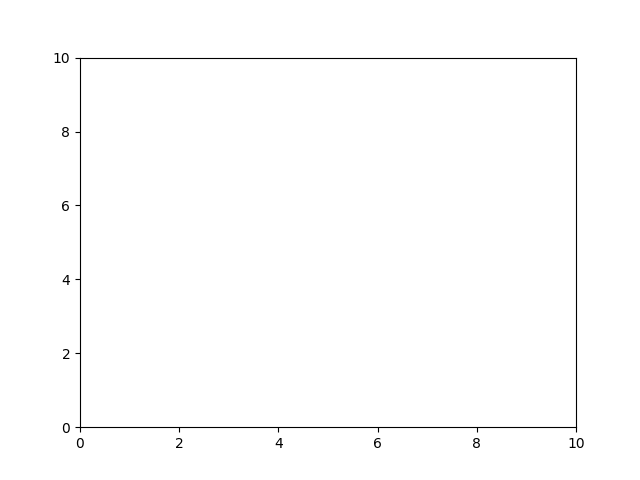

[]


In [18]:
#user input segments
import matplotlib.pyplot as plt
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])

segments_user = []
points_x = []
points_y = []
finished = False
flag = False

def onclick(event):
    global finished, points_x, points_y, flag, segments_user, a
    if event.button == 1:  # Left mouse button (LMB)
        if not finished:
            points_x.append(event.xdata)
            points_y.append(event.ydata)
            plt.plot(points_x, points_y, '.', c='blue')
            for i in range(0, len(points_x), 2):
                plt.plot(points_x[i:i+2], points_y[i:i+2], c='blue')
            if len(points_x)%2:
                plt.plot(points_x[-1], points_y[-1], '.', c='red')
            fig.canvas.draw()
    elif event.button == 3:  # Right mouse button (RMB)
        if len(points_x) > 0:
            col = 'green'
            finished = True
            plt.plot(points_x, points_y, '.', c='green')
            for i in range(0, len(points_x), 2):
                plt.plot(points_x[i:i+2], points_y[i:i+2], c='green')
            for i in range(0, len(points_x), 2):
                segments_user.append(((points_x[i], points_y[i]), (points_x[i+1], points_y[i+1])))
            fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()
print(segments_user)

In [19]:
%matplotlib inline
print(segments_user)


[]


In [20]:
squares = [((1.3306451612903225, 1.1052489590335204), (9.193548387096774, 3.6647727272727275)), ((0.9879032258064515, 2.5825216450216457), (9.798387096774192, 5.6939935064935066)), ((0.06048387096774199, 3.1777597402597406), (9.899193548387096, 7.046807359307359)), ((0.4233870967741935, 6.045725108225109), (8.104838709677418, 8.04788961038961)), ((2.8024193548387095, 0.6885822510822515), (2.4798387096774195, 8.074945887445887)), ((4.69758064516129, 0.7156385281385285), (4.05241935483871, 8.805465367965366)), ((6.290322580645162, 1.1755952380952384), (5.221774193548386, 9.400703463203463))]
name = "posadzka/kratka"
find_intersections(squares)

{((2.5443168148116575, 6.598543821019867), 4, 5),
 ((2.649251155474387, 4.195785906981225), 3, 5),
 ((2.693402163195061, 3.1848281733771584), 2, 5),
 ((2.763847785348818, 1.571783529742838), 1, 5),
 ((4.1941265936308305, 7.028565481109081), 4, 6),
 ((4.3661942394721, 4.870969418740669), 3, 6),
 ((4.451157971182575, 3.8055895090756424), 2, 6),
 ((4.582101403517436, 2.1636594843031443), 1, 6),
 ((5.4861940973986325, 7.365341890153784), 4, 7),
 ((5.740057611296642, 5.411237704108831), 3, 7),
 ((5.882961723918813, 4.311239045813206), 2, 7),
 ((6.097860077824998, 2.6570676113511587), 1, 7)}

{((0.9391534149424783, 5.7431920719199425), 4, 5),
 ((0.9909794402580837, 3.610323035843366), 3, 5),
 ((2.350506693922749, 6.016920464961253), 4, 6),
 ((2.5270360330214157, 4.032075550092659), 3, 6),
 ((2.5984709241244524, 3.2288822618041557), 2, 6),
 ((2.7243104932036006, 1.8139784840451583), 1, 6),
 ((4.467151069945705, 6.4274382795422405), 4, 8),
 ((4.667529962583572, 4.619787422676826), 3, 8),
 ((4.745584709936221, 3.9156427441780615), 2, 8),
 ((4.9117828582794045, 2.4163419879604513), 1, 8),
 ((5.813205635083668, 6.688502152456717), 4, 7),
 ((6.062578892432771, 5.002823696494204), 3, 7),
 ((6.156644204930824, 4.366974157466155), 2, 7),
 ((6.3851912320197375, 2.8220739390809397), 1, 7)}

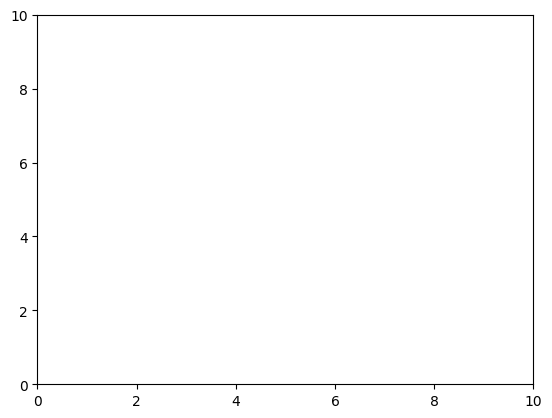

In [21]:
sq = [((1.2903225806451615, 1.4191017316017318), (9.052419354838708, 3.5565476190476195)), ((1.592741935483871, 2.9071969696969697), (9.375, 5.396374458874459)), ((0.30241935483870974, 3.421266233766234), (9.07258064516129, 5.829274891774892)), ((0.685483870967742, 5.6939935064935066), (9.334677419354838, 7.371482683982685)), ((0.8870967741935485, 7.8855519480519485), (1.068548387096774, 0.4180194805194808)), ((2.1169354838709675, 8.643127705627705), (2.8629032258064515, 0.25568181818181857)), ((5.504032258064516, 8.77840909090909), (6.59274193548387, 1.4191017316017318)), ((5.040322580645162, 1.2567640692640694), (4.314516129032258, 7.804383116883117))]
name = "posadzka/kratka"
find_intersections_with_visualization(sq)
find_intersections(sq)

In [22]:
cr = [((1.6431451612903225, 1.6795183982683985), (8.639112903225806, 3.1676136363636362)), ((2.247983870967742, 3.1946699134199137), (9.445564516129032, 5.7379599567099575)), ((3.1350806451612905, 5.44034090909091), (9.12298387096774, 8.849431818181818)), ((3.4778225806451615, 9.309388528138529), (7.691532258064516, 0.5160984848484851)), ((8.881048387096774, 9.5799512987013), (8.054435483870966, 1.868912337662338))]
find_intersections(cr)
find_intersections_with_visualization(cr)

{((4.860991071196485, 6.422952905548046), 3, 4),
 ((5.805579528727108, 4.451758657609807), 2, 4),
 ((6.626118467333096, 2.7394344987715264), 1, 4),
 ((8.183260162425228, 3.0706503115055472), 1, 5),
 ((8.430752040370114, 5.379372454513748), 2, 5),
 ((8.78192223326186, 8.655255311866258), 3, 5)}

In [23]:
starting = [((0,0), (4,4)),
            ((1,1), (-1,3)),
            ((2,2), (3,1))]
find_intersections_with_visualization(starting)

{((1.0, 1.0), 1, 2), ((2.0, 2.0), 1, 3)}

In [24]:
test = [((0,0), (4,4)),
        ((-1,2), (8,11)),
        ((1,1), (5,8)),
        ((2,2), (6,9)),
        ((3,3), (7,10))]
find_intersections_with_visualization(test)

{((1.0, 1.0), 1, 3),
 ((2.0, 2.0), 1, 4),
 ((3.0, 3.0), 1, 5),
 ((5.0, 8.0), 2, 3),
 ((6.0, 9.0), 2, 4),
 ((7.0, 10.0), 2, 5)}

In [25]:
name = "początki/końce"
test2 = [((0.0,0.0),(2.0,0.0)), ((1,0), (1.5, 1)), ((1.2,0), (1.7, 1)), ((0.8,0), (1.3, 1)), ((0.1,1), (1.9, 1)), ((0.2, 0.5), (1.95, 0.5))]
find_intersections_with_visualization(test2)
find_intersections(test2)

{((0.8, 0.0), 1, 4),
 ((1.0, 0.0), 1, 2),
 ((1.05, 0.5), 4, 6),
 ((1.2, 0.0), 1, 3),
 ((1.25, 0.5), 2, 6),
 ((1.3, 1.0), 4, 5),
 ((1.45, 0.5), 3, 6),
 ((1.5, 1.0), 2, 5),
 ((1.7, 1.0), 3, 5)}